<h1>Example: Heisenberg Model</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
###
### General imports
###


import numpy              as np
import numpy.linalg       as la
import scipy.integrate    as spi
import matplotlib.pyplot  as plt


###
### Operator simulation & Hamiltonian
### preperation imports
###
from   pyLIQTR.sim_methods.simqsp             import SimQSP
import pyLIQTR.sim_methods.quantum_ops        as     qops    
   

###
### Ploting and text output settings
###

np.set_printoptions(precision=2)



<hr>
<h2><u>Heisenberg Model</u></h2>
<h3>Background</h3>

This notebook describes how `pyLIQTR` can be used to simulate the spin$-1/2$ Heisenberg model.  While this terminology tends to suggest a single physical problem, the associated Heisenberg Hamiltonian can actually accommodate a broad range of $k$-local physics. Stated succinctly, we define this as

\begin{equation}
H =  \sum_{\langle j,k \rangle} \left[ J^x_{j,k} (X_{j} \otimes X_{k}) + J^y_{j,k}  (Y_j \otimes Y_{k}) + 
J^z_{j,k} (Z_j  \otimes  Z_{k}) \right] + 
\sum_j \left[ h^{x}_j X_j + h^{y}_j Y_j +  h^{z}_j Z_j \right], 
\end{equation}

where $\{X_j, Y_j, Z_j\}$ are Pauli spin operators acting on site (vertex) $j$ of some lattice (graph).  This construction assumes that there is a single spin at each lattice site (vertex), with the notation $\langle j,k \rangle$ used to denote a summation over  pairs of these sites. It is immediately apparent that there are two key components to this model: a set of pairwise spin-spin couplings (e.g., $X_{j} \otimes X_{k}$) between spins on sites $j$ and $k$, and a set of local fields  (e.g., $X_j$) at each spin site. The real constants $J^{x (y,z)}_{j,k}$ and $h^{x (y,z)}_j$ reflect the strengths of these respective interactions.  A slightly more subtle $-$ but equally important $-$ fact is that these pairwise interactions can be defined for a system of any spatial dimensionality or lattice geometry.

We can use this formality to gain a bit of physical intuition.  Notably, the Pauli operators can be used to define a vector spin $\vec{s} |\psi \rangle =  \big(s_x X + s_y Y + s_z Z\big) | \psi \rangle$ through action of the operator $\hat{\sigma} = (X + Y + Z)$ on a spinor wavefunction (this is just the action of the tangent space basis elements in $\mathfrak{su}(2)$ acting on a function).  The tensor product then gives a construct analogous to the dot product of these spins

\begin{split}
\vec{s}_1 \cdot \vec{s}_2 & = s_{x,1} s_{x,2} + s_{y,1} s_{y,2} + s_{z,1} s_{z,2} \\
& = \big(\langle \psi_1 | \otimes \langle \psi_2 | \big) \cdot \big[ X\otimes X + Y\otimes Y + Z \otimes Z\big] \cdot \big( |\psi_1 \rangle \otimes | \psi_2 \rangle\big)
\end{split}

and draws a concrete analogy with the classical Heisenberg Hamiltonian

\begin{equation}
H = \sum_{\langle i j\rangle} \vec{S}_1 \cdot \vec{S}_2
\end{equation}

where $\vec{S}_i \in \mathbb{R}^3$ are classical spin vectors.
<hr>

The Heisenberg model holds a special place in the context of quantum computation and quantum simulation.  Notably, this Hamiltonian is directly assembled from the Pauli operators $\{X, Y, Z\}$, which generate a complex representation of the $\mathfrak{su(2)}$ algebra.  Moreover, the time evolution of a local coupling gives an  an $SU(2)$ rotation $-$ and thus the $\{R_x, R_y, R_z \}$ rotation gates $-$ by action of the exponential map.  These operations are fundamental to qubit-based architectures, making this model and its descendants a natural framework for quantum simulation.  

Aside from computational frameworks, the Heisenberg Hamiltonian has been used to model physical systems that span from molecular magnets to spin-density waves to far-flung analogues of  hydrodynamic phenomena.  Many interesting spin models are actually formal limits of this Hamiltonian, including the XXZ model and the transverse-field Ising model), which we examine at length in a separate notebook.  Moreover, this broad application space has motivated the development of extensive  analytical treatments.  Several limits of the Heisenberg model have thus been proven integrable, demonstrating that they can be simulated in polynomial time using classical resources.   Nonetheless, these analytical results remain limited in scope and most parameter regimes still constitute quantum hard problems.  

In the case of the Heisenberg model, this hardness reflects a remarkable degree of  generality.  It is fairly straightforward to demonstrate how an arbitrary $k$-local Hamiltonian can simulate bosons, fermions, or qudit systems (e.g., via the Jordan-Winger transform for Fermions, etc.).  A more nontrivial effort has shown that the Heisenberg model is actually universal for the simulation of these $k$-local Hamiltonians and thus can capture the same range of phenomena.  While this reductive approach might not be advantageous for all such simulation problems, they remain fundamentally simulable as instances as of the Heisenberg Hamiltonian.

We will demonstrate the capabilities of `pyLIQTR` by working with this model in several limits of physical intereset.
<h3>Background: 1-d Heisenberg Model</h3>
To streamline our discussion, we will consider a limiting regime of the Heisenberg Hamiltonian.  More specifically, we will work with a one-dimensional spin chain with nearest-neighbor interactions:

\begin{equation}
H =  \sum_{j=1}^{N-1} \left[ J^x_j (X_j \otimes X_{j+1}) + J^y_j  (Y_j \otimes Y_{j+1}) + 
J^z_j (Z_j  \otimes  Z_{j+1}) \right] + 
\sum_{j=1}^N \left[ h^{x}_j X_j + h^{y}_j Y_j +  h^{z}_j Z_j \right]
\end{equation}

where the local couplings $J^{x (y,z)}_j$ and fields $h^{x (y,z)}_j$ may vary from site-to-site when disorder is present, but are otherwise constant.  The dynamics in our simulations will be driven by a quench from an initial product state $-$ that is, we instantaneously apply a new Hamiltonian for which  $|\psi_0\rangle$  is not an eigenstate.

We will approach two cases in our discussion:


1. <b> General Heisenberg Antiferromagnet:</b> In this case we have antiferromagnetic spin-spin couplings $J^{x (y,z)}_j = J^{x (y,z)} > 0$ </li>  and a set of nonzero applied fields $h^{x (y,z)}_j = h^{x (y,z)}$. We will consider a quench from the product state $|\psi(0)\rangle = \otimes_{j=1}^N |Z+\rangle$ where $|Z+\rangle = |\uparrow_i\rangle$ is the "spin-up" eigenstate of the Pauli $Z$ operator.  
2. <b> XXZ Hamiltonian:</b> Here we have an instance with $J^{x,y}_j = J$ and $J^{z}_j = J_z$.  External fields $h^{x (y,z)}_j = h^{x (y,z)}$ may or may not be present. We again consider a quench from the product state $|\psi(0)\rangle = \otimes_{j=1}^N |Z+\rangle$ where $|Z+\rangle = |\uparrow_i\rangle$ is the "spin-up" eigenstate of the Pauli $Z$ operator.  This model exhibits a phase transition between XY and Ferromagnetic regimes when $J/J_z \longrightarrow -1$.

<h3>Heisenberg Hamiltonian Parameters</h3>

To facilitate our discussion, separate input blocks are provided for each Heisenberg instance outlined above.  Since the remainder of the notebook is case-independent, it is only necessary to run evaluate the cells for the particular problem(s) of interest.

<h4>Model 1: General Heisenberg Antiferromagnet</h4>

Here we define the Hamiltonian for an $N = 3$ site antiferromagnetic Heisenberg model.  It is conveneient to specify parameters in terms of $J_z$, which will set a characteristic energy for the system.

Run the below cell only if you're interested in Model 1

In [2]:

N    =   3;       

J_z  =   0.5;

J_x  =   2.0*J_z;     J_y  =   0.5*J_z;               
h_x  =  -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.1*J_z;


<h4>Model 2: XXZ Hamiltonian</h4>

Here we define the Hamiltonian for an $N = 3$ site homogeneous XXZ model, just outside of the XY to ferromagnetic transition ($J^z = 1.0$, $J^x = J^y = 1.1 \cdot J^z$). We also include a $h^x$ term to drive some interesting dynamics.

Run the below cell only if you're interested in Model 2

In [3]:

N    =    3;       

J_z  =    1.0;

J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;


<h3>Generating Heisenberg Hamiltonians</h3>

 PyLIQTR provides a `params_heisenberg_1d` method within the `quantum_ops` module.  This routine can generate input parameter sets for a range of Heisenberg-type models:

In [4]:

tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)


Note that there is also an optional keyword argument `periodic` which allows us to generate a Hamiltonian with periodic boundary conditions. The returned objects describe this Hamiltonian: `tuples` enumerates the lattice sites which are coupled,  `types` describes the nature of these couplings, and the corresponding coefficients are placed into `coeffs`.  For this example:


In [5]:

print("\nSites     \t Type \t\t Coefficient\n",end="")
print("-"*50,"\n")
for j in range(len(tuples)):
    print(tuples[j],"\t\t", types[j], "\t\t", coeffs[j])
print("")



Sites     	 Type 		 Coefficient
-------------------------------------------------- 

(0, 1) 		 XX 		 1.1
(1, 2) 		 XX 		 1.1
(0, 1) 		 YY 		 1.1
(1, 2) 		 YY 		 1.1
(0, 1) 		 ZZ 		 1.0
(1, 2) 		 ZZ 		 1.0
0 		 X 		 -1.0
1 		 X 		 -1.0
2 		 X 		 -1.0



which corresponds to the four-site Heisenberg Hamiltonian:


\begin{equation}
H =  \sum_{j=1}^{3} \left[ J^x (X_j \otimes X_{j+1}) + J^y  (Y_j \otimes Y_{j+1}) + 
J^z (Z_j  \otimes  Z_{j+1}) \right] + 
\sum_{j=1}^4 \left[ h^{x}_j X_j + h^{y}_j Y_j +  h^{z}_j Z_j \right]
\end{equation}



<i><b>Generating Pauli Strings<b></i>

The circuit preparation routines in `pyLIQTR` require that we specify Pauli strings as input. An isolated set of these can be produced by passing the preceding output the `ps_text_full_set` function:


In [6]:
tuples_full = qops.ps_text_full_set(tuples,types,N)

print("\nStrings     \n",end="")
print("-"*50,"\n")
for j in range(len(tuples)):
    print(tuples_full[j])
print("")


Strings     
-------------------------------------------------- 

XXI
IXX
YYI
IYY
ZZI
IZZ
XII
IXI
IIX




Conspicuously absent are numerical values for the couplings and fields, which will also be used to generate circuits.  We can generate more pertinent output by passing the coefficients as a keyword argument to `ps_text_full_set`:


In [7]:

ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs)
ham_strings


[('XXI', 1.1),
 ('IXX', 1.1),
 ('YYI', 1.1),
 ('IYY', 1.1),
 ('ZZI', 1.0),
 ('IZZ', 1.0),
 ('XII', -1.0),
 ('IXI', -1.0),
 ('IIX', -1.0)]

The resulting array of tuples can be used directly with `pyLIQTR`'s circuit generation code.
<b><i>Generating a Hamiltonian Matrix</i></b>
The Pauli string tuples can also be used to generate a matrix representation of the Hamiltonian, which is particularly useful for classical reference simulations.  This is accomplished by invoking  the `ham_from_pauli_tuples` routine:

In [8]:

H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)


<h3>Classical Simulation</h3>


Although our goal is to generate circuits for quantum simulation, it is helpful to have some classical reference values on hand as a sanity check.  To this end, we can use the Hamitonian matrix $H$ that was generated by `ham_from_pauli_tuples` to numerically integrate the Heisenberg model following a field quench.  We begin by setting some initial parameters:

In [9]:


dt            =  0.2                             # Integration timestep, Decrease this 
                                                 #   if you'd like a finer grain simulation
tmax          =  2.0                             # Maximal timestep
sclf          =  1                               # Scale factor for timestep sampling
N_ts          =  int(np.ceil(tmax/dt))           # Total number of timesteps
timestep_vec  =  np.arange(0,tmax+dt,sclf*dt)    # Define array of timesteps


Next, we build up the initial wavefunction as a spin-up product state $\mid\psi_0\rangle = \bigotimes_{j=0}^{N-1} \mid \uparrow\rangle$ so that:

In [10]:

psi0 = qops.multikron([qops.sz_u]*N)             # Generate the wavefunction as a 
psi0 = psi0 / la.norm(psi0)                      # Kronecker product and normalize it.

psi0_vec = qops.vectorize_cvec(psi0)             # Vectorize the initial wavefunction



We can verify the local expectation value of $Z_j$ on each site of the lattice:


In [11]:

print(qops.measure_obs_site(psi0,qops.pz).real)


[1. 1. 1.]


The derivative $\partial_t \mid\psi\rangle = -\imath H \mid \psi\rangle$ is given by the function `prop_wfn` in the `quantum_ops` module.  This allows us to use ODEPACK methods to integrate the wavefunction: 

In [12]:

traj_raw_wfn = spi.odeint(qops.prop_wfn,psi0_vec,timestep_vec,args=(H,),atol=1e-16)


There is also a method `parse_wfn_traj` which can evaluate a single qubit observable on every qubit for every timestep in the trajectory (or, alternatively, an N-qubit observable for every timestep).  We evaluate this for the spin-up projector `przp` $= (1 + Z)/2$:

In [13]:

traj_proc_wfn = qops.parse_wfn_traj(timestep_vec,traj_raw_wfn,qops.przp)

obs_reference = traj_proc_wfn[:,1:(N+1)].real

Finally, we plot the time evolution of our observable:

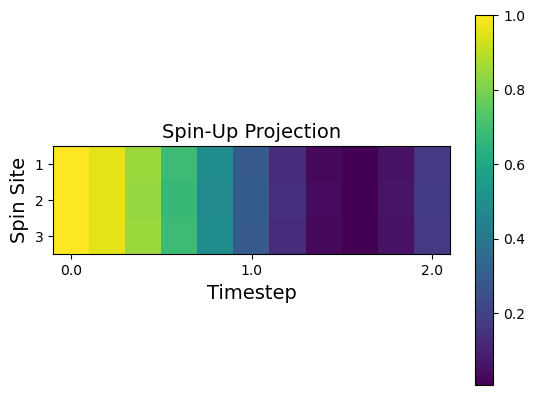

In [14]:

N_ticks = 2

#aspect = 1/0.05
aspect  = 1.0

plt.imshow(np.transpose(obs_reference),
           cmap='viridis', interpolation='nearest', aspect=aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)

plt.yticks(range(0,N),range(1,N+1))
plt.xticks(np.arange(0,N_ts+1,N_ts/N_ticks),labels=np.arange(0,tmax+dt,int(tmax/N_ticks)))

plt.colorbar()

plt.show()

